In [1]:
from pyhmc import hmc
import autograd.numpy as np  # Thinly-wrapped numpy
import autograd.scipy as scipy
from autograd import grad    # The only autograd function you may ever need
from autograd import jacobian  
from autograd import elementwise_grad as egrad 
from scipy.special import gamma
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
def tanh(x,z):
    
    y = np.exp(-2.0*x*z)
    return (1.0 - y) / (1.0 + y)


def plano(x, param):
    
    
    return x[0]+2*x[1]+param

x = np.linspace(-7, 7, 200)

grad(plano)(np.array([0.4, 0.3]), 0.5)


array([1., 2.])

In [43]:
L = 24.0

def S(tau, theta):
    
    return theta[0]**2*np.exp(tau**2/theta[1]**2)

def Lambda(n,L):
    return (n+1)*np.pi/(2*L)

def gamma_plus(i,j,L):
    
    return Lambda(i,L) + Lambda(j,L)

def gamma_minus(i,j,L):
    
    return Lambda(i,L) - Lambda(j,L)


        
def psi(x,i,j,L):
    
    if i==j:
        
        t1 = 1/(2*L)*x
        t2 = np.sin(gamma_plus(j,j,L)*(x+L) )/(2*L*gamma_plus(j,j,L)) - np.sin(gamma_plus(j,j,L)*(L) )/(2*L*gamma_plus(j,j,L))
        
        return t1 - t2
    
    else:
        
        t1 = np.sin(gamma_minus(i,j,L)*(x+L) )/(2*L*gamma_minus(i,j,L)) - np.sin(gamma_minus(i,j,L)*(L) )/(2*L*gamma_minus(i,j,L))
        t2 = np.sin(gamma_plus(i,j,L)*(x+L) )/(2*L*gamma_plus(i,j,L)) - np.sin(gamma_plus(i,j,L)*(L) )/(2*L*gamma_plus(i,j,L))

        return t1 - t2

        
def Psi(x,L, N):

    MPsi = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            MPsi[i,j] = psi(x,i,j,L)
            
    return MPsi
        
        
def g(x, f_0, alpha):
    
    MPsi = Psi(x,L, len(alpha))
    
    return f_0 + alpha.T@ (MPsi@alpha)


def f(x, f_0, alpha):
    
    N = len(alpha)
    
    #MPsi = Psi(x,L, N)
    
    quad = 0
    
    
    for i in range(0,N):
        for j in range(0,N):
            quad = psi(x,i,j,L) * alpha[i] * alpha[j]
    
    
    return f_0 + quad#alpha.T@ (MPsi@alpha)


def f(x, f_0, alpha, MPsi):

    
    return f_0 + alpha.T@ (MPsi@alpha)


    
def Pre_Mat(N, theta):
    
    u = np.zeros(N)
    
    for i in range(N):
        
        u[i] = 1/S(Lambda(i, L), theta)
        
    return np.diag(u)


def ker(x,y):
    
    return 1.0 +x*y*0




In [4]:
def log_likelihood(f_0, alpha, Y, X, C, mu, MPsi):
    
#     f_0 = beta[0]
#     alpha = beta[1:]
  
    l = 0
    
    for i in range(len(Y)):
        

        sigma2 = f(C[i], f_0, alpha, MPsi[i])
        
                
        l += -( mu - Y[i]  )**2/sigma2 - np.log(sigma2)
    
    
    return l

def logp_f_0(log_f, theta1, theta2):
    
    f_0 = np.exp(log_f)
    
    #return - (f_0-theta1)**2/theta2
    
    
    return  (theta1 -1)*log_f - theta2*f_0 + theta1*np.log(theta2) - np.log(gamma(theta1))

def logp_alpha(alpha, theta):
    
    
    l = 0
    
    for i in range(len(alpha)):
        
        if S(Lambda(i,L), theta) <= 0.0:
            print('Problema en S')
        
        l += -0.5*(alpha[i]**2/ S(Lambda(i,L), theta )) - 0.5*np.log(S(Lambda(i,L),theta ))
    
    return l


def logp_mu(mu):
    
    return -0.5*mu**2/1 - 0.5*np.log(1)


def log_p(beta, mu, theta1, theta2, theta, Y,X, C, MPsi):
    
    if beta[0] > 1000:
        print("aqui hay problema que g_0 es muy grande")
    
    f_0 = np.exp(beta[0]) 
    alpha = beta[1:]
    
    return logp_mu(mu) + logp_alpha(alpha, theta)+ logp_f_0(beta[0], theta1, theta2)+log_likelihood(f_0, alpha, Y, X, C, mu, MPsi)




In [5]:
#Gaussian process in the param

def log_likelihood_GP(f_0, alpha, Y, K, C, MPsi):
    
  
    
    D = np.zeros(len(C))
    

    for i in range(len(C)):
        #we add a little noise to the diagonal to ensure PD of the matrix
#         f(C[i], f_0, alpha)
#         print(A[i,i], i)
        e_i = np.zeros(len(C))
        e_i[i] = 1.0
        sigma2 = f(C[i], f_0, alpha, MPsi[i])
        D += sigma2*e_i  
    
    A = K + np.eye(len(C))*D
    
    x = np.linalg.solve(A, Y)
    
    return -0.5*np.dot(Y,x) - 0.5*np.log(np.linalg.det(A))
    
#     
    
    
#     return -0.5*np.dot(Y,x) - 0.5*np.log(np.linalg.det(A))
    


def log_p_GP(beta, theta1, theta2, theta, Y,K, C, MPsi):
    
    f_0 = np.exp(beta[0]) 
    alpha = beta[1:]
    
    return logp_alpha(alpha, theta)+ logp_f_0(f_0, theta1, theta2)+log_likelihood_GP(f_0, alpha, Y, K, C, MPsi)




In [66]:
# def g(c):
#     return np.array([c ** 0, c, c ** 2]).squeeze()

def g_tilde(c, w_0=0.5, w_1=7, w_2 = 10):
    return w_0 ** 2 + (w_1 ** 2) * c + w_2**2 *c**2



mu = 3

def g(c, w_0=0.5, w_1=7, w_2 = 10):
    return g_tilde(c, w_0, w_1, w_2)/g_tilde(6, w_0, w_1, w_2) * mu**2




w_0 = 1.1
w_1 = np.sqrt(1.5)
w_2 = np.sqrt(np.sqrt(0.1))
w = np.array([w_0, w_1, w_2]).squeeze()

print(g_tilde(6, w_0, w_1, w_2))

w_0_equiv = 1.1/np.sqrt(21.594199576606165) * mu
w_1_equiv = np.sqrt(1.5)/np.sqrt(21.594199576606165) * mu
w_2_equiv = np.sqrt(np.sqrt(0.1))/np.sqrt(21.594199576606165) * mu
w_equiv = np.array([w_0_equiv, w_1_equiv, w_2_equiv]).squeeze()



num_samples = 50




X = np.linspace(0,1, num_samples)

# C = np.concatenate(  (np.linspace(0.0, 0.5, 10), np.linspace(2., 2.5, num_samples - 10) ) )
C = np.concatenate(  (np.linspace(1.0, 2., 10), np.linspace(4., 6., num_samples - 10) ) )

sigma2 = g(C, *w_equiv)


eps = []

for sigma in sigma2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
Y = mu + eps


21.594199576606165


-6.051321674568555
-20.028541585287357
-11.7013205133904


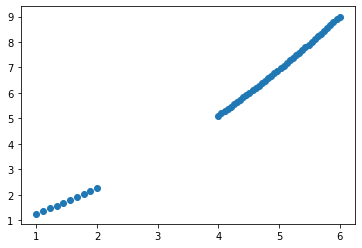

In [36]:
# w_0_equiv = 1.1/np.sqrt(21.594199576606165) * 3
# w_1_equiv = np.sqrt(1.5)/np.sqrt(21.594199576606165) * 3
# w_2_equiv = np.sqrt(0.1)/np.sqrt(21.594199576606165) * 3
# w_equiv = np.array([w_0_equiv, w_1_equiv, w_2_equiv]).squeeze()

# print(np.mean(Y))
# print(np.mean(Y[:10]))
# print(np.mean(Y[10:]))
plt.scatter(C, sigma2)


# to find right set of parameters


def second_aprox(Y, sigma2):
    
    pres = 1/sigma2
    
    tot = np.sum(pres)
    
    return 1/tot * np.dot(Y,pres)


print(np.mean(Y)/3*100 -1 *100)
print(np.mean(Y[:10])/3*100 -1 *100)
print(second_aprox(Y, sigma2)/3*100 -1 *100)


## Marvin Code

In [50]:
theta1 = 3.0
theta2 = 3.
theta = np.array([1.0, 4.0])

# Theta = np.array([5,1, 1.0,1.0])



K = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        K[i,j] = ker(X[i], X[j])
        
        
beta_0 = np.array([0.4, 0.4, 1.0, 0.4, 0.4, 0.4, 0.5, 0.6, 1, 2, 0.3, 0.1])



N = len(beta_0) - 2


MPsi = []

for i in range(len(C)):
    
    MPsi.append(Psi(C[i],L, N))


In [51]:
len(C)

50

In [68]:
log_Evidence(theta, beta_0)

evaluating log_evidence


149.72302466441735

In [52]:
#Hyper Parameters
import time

t0 = time.time()

#Hyper mean



# Kernel of the GP



def log_Evidence(theta, beta_0):
    
    print("evaluating log_evidence")
    
#     theta = Theta[:2]
#     theta1 = Theta[2]
#     theta2 = Theta[3]
    
#     theta = np.exp(log_theta)

    
    to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


    nab_p = lambda beta: grad(to_opti)(beta)
    
    
    Hess = lambda beta: jacobian(nab_p)(beta)

    beta = minimize(to_opti, beta_0 , jac=nab_p, hess = Hess, method='Newton-CG', options={"xtol": 0.01}).x
    
   
    A = Hess(beta_0)

    det = np.linalg.det(A*2*np.pi)
    
 
    
#     print( A )
    
    return -(-to_opti(beta) - 0.5*np.log(det))



def maximum_posterior(beta_0):
    
    to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


    nab_p = lambda beta: grad(to_opti)(beta)
    
    Hess = lambda beta: jacobian(nab_p)(beta)

    beta = minimize(to_opti, beta_0 , jac=nab_p, hess = Hess,method='Newton-CG').x
    
    
#     det = np.linalg.det(Hess*2*np.pi)
    
    return beta





# log_p(beta_0, 0.4, 0.4, 0.5, np.array([0.4, 0.4]), Y, X, C)

beta_0 = maximum_posterior(beta_0)
print(beta_0)
# print(beta_0)






# print(beta)
t0 = time.time()

theta_optimum = minimize(log_Evidence, theta, args=(beta_0,) , method='Powell', options = {'maxfev':40}).x
print(time.time() - t0)

print(theta_optimum)

# theta = np.exp(log_theta)

to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta_optimum, Y, X, C, MPsi)


nab_p = lambda beta: grad(to_opti)(beta)

beta = minimize(to_opti, beta_0, jac=nab_p, method='Newton-CG').x




[ 2.86947898 -0.15824469  1.4366478  -0.49613639 -1.22291563  0.89118283
  0.84566348 -1.10972873 -0.39196236  1.12073424 -0.03731257 -0.94412476]
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating lo

In [53]:
beta, theta1, theta2, theta_optimum, Y.shape, X.shape, C.shape, np.array(MPsi).shape

(array([ 2.83023191, -0.29742301,  1.63283571, -0.58216585, -1.35564796,
         1.03190171,  0.86203981, -1.2422532 , -0.26507859,  1.15664737,
        -0.28945237, -0.78886435]),
 3.0,
 3.0,
 array([2.55917580e+00, 4.78811091e+05]),
 (50,),
 (50,),
 (50,),
 (50, 10, 10))

In [54]:
print(theta_optimum)
print(beta)

to_sample = lambda beta: log_p(beta[1:], beta[0], theta1, theta2, theta_optimum, Y, X, C, MPsi)


grad_p = lambda beta: grad(to_sample)(beta)

def logprob(beta):
    
    return to_sample(beta), grad_p(beta) 


samples = hmc(logprob, x0=beta, n_samples=500, epsilon = 0.1)



[2.55917580e+00 4.78811091e+05]
[ 2.83023191 -0.29742301  1.63283571 -0.58216585 -1.35564796  1.03190171
  0.86203981 -1.2422532  -0.26507859  1.15664737 -0.28945237 -0.78886435]


In [55]:
# def sigma_fn(c, w_0=0.5, w_1=7):
#     return w_0 ** 2 + (w_1 ** 2) * c

# def sigma_dw_0(c, w_0, w_1):
#     return 2 * w_0

# def sigma_dw_1(c, w_0, w_1):
#     return 2 * w_1 * c


# def gamma_fn(c, w_0=0.1, w_1=0.5):
#     return w_0 ** 2 + (w_1 ** 2) * c

# def gamma_dw_0(c, w_0, w_1):
#     return 2 * w_0

# def gamma_dw_1(c, w_0, w_1):
#     return 2 * w_1 * c


# def g_tilde(c, w_0=0.5, w_1=7, w_2 = 10):
#     return w_0 ** 2 + (w_1 ** 2) * c + w_2**2 *c**2

# def g(c, w_0=0.5, w_1=7, w_2 = 10):
#     return g_tilde(c, w_0, w_1, w_2)/g_tilde(6, w_0, w_1, w_2) * mu**2

# def second_aprox(Y, sigma2):
    
#     pres = 1/sigma2
    
#     tot = np.sum(pres)
    
#     return 1/tot * np.dot(Y,pres)

# def psi(x,i,j,L):
    
#     if i==j:
        
#         t1 = 1/(2*L)*x
#         t2 = np.sin(gamma_plus(j,j,L)*(x+L) )/(2*L*gamma_plus(j,j,L)) - np.sin(gamma_plus(j,j,L)*(L) )/(2*L*gamma_plus(j,j,L))
        
#         return t1 - t2
    
#     else:
        
#         t1 = np.sin(gamma_minus(i,j,L)*(x+L) )/(2*L*gamma_minus(i,j,L)) - np.sin(gamma_minus(i,j,L)*(L) )/(2*L*gamma_minus(i,j,L))
#         t2 = np.sin(gamma_plus(i,j,L)*(x+L) )/(2*L*gamma_plus(i,j,L)) - np.sin(gamma_plus(i,j,L)*(L) )/(2*L*gamma_plus(i,j,L))

#         return t1 - t2

        
# def Psi(x,L, N):

#     MPsi = np.zeros((N,N))
#     for i in range(0,N):
#         for j in range(0,N):
#             MPsi[i,j] = psi(x,i,j,L)
            
#     return MPsi

L = 24.0

X = np.linspace(0,1, num_samples)
num_samples = 50
mu = 3

w_0_equiv = 1.1/np.sqrt(21.594199576606165) * mu
w_1_equiv = np.sqrt(1.5)/np.sqrt(21.594199576606165) * mu
w_2_equiv = np.sqrt(np.sqrt(0.1))/np.sqrt(21.594199576606165) * mu
w_equiv = np.array([w_0_equiv, w_1_equiv, w_2_equiv]).squeeze()


# c = np.random.rand(num_samples)
C = np.concatenate((np.linspace(1.0, 2., 10), np.linspace(4., 6., num_samples - 10)))
sigma_2 = g(C, *w_equiv)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
Y = mu + eps

Text(0.5, 1.0, 'Parametric Regression, Parametric Variance: Reconstruction of $g(c)$')

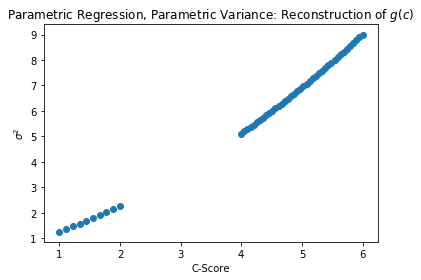

In [56]:
plt.scatter(C, sigma_2)
plt.xlabel("C-Score")
plt.ylabel("$\sigma^2$")
plt.title('Parametric Regression, Parametric Variance: Reconstruction of $g(c)$')

In [57]:
MPsi = []

for i in range(len(C)):
    
    MPsi.append(Psi(C[i],L, N))
    
# theta_optimum = np.array([0.04635802, 2.21489177])
# beta = np.array([ 1.43732340e+00,  1.12126097e-01, -1.42323154e-01, -1.03483569e-01,
#        -3.03634735e-02, -4.78619386e-02, -2.04207881e+00, -4.85396220e-12,
#        -4.88629106e-14,  7.67838751e-12, -8.70497366e-12, -1.03608578e-11,
#        -2.02489771e-13, -7.69181423e-13, -6.98529823e-12, -5.74456208e-12,
#        -3.65461512e-12])

to_sample = lambda beta: log_p(beta[1:], beta[0], theta1, theta2, theta_optimum, Y, X, C, MPsi)


grad_p = lambda beta: grad(to_sample)(beta)

def logprob(beta):
    
    return to_sample(beta), grad_p(beta) 


samples = hmc(logprob, x0=beta, n_samples=500, epsilon = 0.1)

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


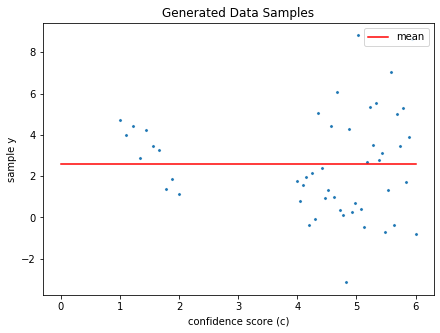

In [61]:
plt.figure(figsize=(7, 5))
sns.scatterplot(C, Y, s=10)

# Bigger c value = more variance/uncertainty
plt.xlabel('confidence score (c)')
plt.ylabel('sample y')
plt.title("Generated Data Samples")
plt.plot([0, 6], [Y.mean(), Y.mean()], 'r', label='mean')
plt.legend(loc='upper right');

2.6976205777409263


[Text(0, 0.5, 'number of samples'),
 Text(0.5, 0, '$\\mu$'),
 Text(0.5, 1.0, 'Histogram for the mean')]

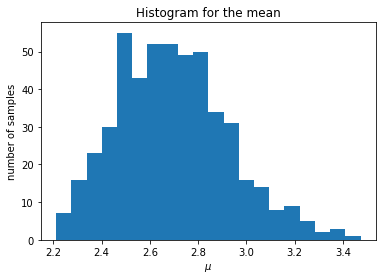

In [62]:
C_test = np.linspace(0,2.5, 100)
aproximation_sampler = np.zeros( (len(C_test),500) )



MPsi_test = []

for i in range(len(C_test)):
    
    MPsi_test.append(Psi(C_test[i],L, N))


for i in range(len(C_test)):
    
    for j in range(500):
    
        aproximation_sampler[i,j] = f(C_test[i], np.exp(samples[j][1]), samples[j][2:], MPsi_test[i])
        
aproximate_mean = np.mean(aproximation_sampler, axis = 1)

aproximate_std = np.std(aproximation_sampler, axis = 1)


print(np.mean(samples[:,0]))


fig, ax = plt.subplots()

ax.hist(samples[:,0], bins = 20)
ax.set(ylabel='number of samples', xlabel='$\mu$', title='Histogram for the mean')




[Text(0, 0.5, '$\\sigma^2$'),
 Text(0.5, 0, 'c score'),
 Text(0.5, 1.0, 'Reconstruction of $g(c)$')]

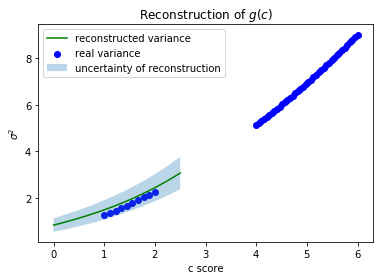

In [63]:
fig, ax = plt.subplots()

ax.scatter(C, sigma2, c='b', label = 'real variance')
ax.plot(C_test, aproximate_mean, c = 'g', label = 'reconstructed variance')
ax.fill_between(C_test, aproximate_mean -  aproximate_std,aproximate_mean +  aproximate_std, alpha=0.3, label = 'uncertainty of reconstruction')
# ax.plot(C_test, aproximate_mean -  aproximate_std)
ax.legend()


ax.set(xlabel='c score', ylabel='$\sigma^2$', title='Reconstruction of $g(c)$')




In [64]:
aproximation = np.zeros(len(C))

Pres = jacobian(nab_p)(beta_0)


Sigma = np.linalg.inv(Pres[2:, 2:])




for i in range(num_samples):
    
    aproximation[i] = f(C[i], np.exp(beta[1]), beta[2:], MPsi[i]) + np.sum(Sigma*MPsi[i])
    
print(aproximation)

[ 1.80294777  1.96265382  2.13130382  2.30880631  2.49498519  2.68958119
  2.89225463  3.10258906  3.32009615  3.54422143  7.89369537  7.99412876
  8.09333854  8.19130403  8.28800766  8.38343493  8.47757444  8.57041776
  8.66195947  8.75219705  8.84113083  8.92876395  9.01510224  9.10015415
  9.18393068  9.26644526  9.34771365  9.42775385  9.50658598  9.58423216
  9.66071641  9.73606451  9.81030387  9.88346344  9.95557356 10.02666583
 10.09677299 10.1659288  10.23416789 10.30152566 10.36803814 10.43374188
 10.49867381 10.56287115 10.62637128 10.68921163 10.75142958 10.81306235
 10.87414691 10.93471988]


[Text(0, 0.5, '$\\sigma^2$'),
 Text(0.5, 0, 'c score'),
 Text(0.5, 1.0, 'Parametric Regression, Parametric Variance: Reconstruction of $g(c)$')]

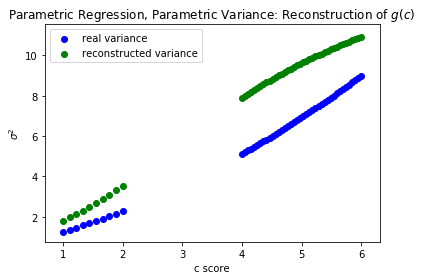

In [65]:
fig, ax = plt.subplots()

ax.scatter(C, sigma2, c='b', label = 'real variance')
ax.scatter(C, aproximation, c = 'g', label = 'reconstructed variance')
ax.legend()


ax.set(xlabel='c score', ylabel='$\sigma^2$', title='Parametric Regression, Parametric Variance: Reconstruction of $g(c)$')



In [15]:
print(beta)

[ 3.05551791 -0.66471886  0.91085701 -0.71396829 -0.55515626  1.29271851
 -0.11365812 -1.61467259  1.01666772  1.58187129 -2.04920826 -1.12332766]


In [16]:
print((np.mean(Y) - 3)/3)
print((beta[0] -3)/3)
print((np.mean(Y[:10]) -3 )/3)
print( (np.mean(samples[:,0]) -3 )/3 )

-0.04870992617479356
0.018505970494419415
0.08363287433937305
0.011550087027222933


In [17]:
def second_aprox(Y, sigma2):
    
    pres = 1/sigma2
    
    tot = np.sum(pres)
    
    return 1/tot * np.dot(Y,pres)

second_aprox(Y, aproximation)

3.1055540052826247

Linear regression Model

28.6927569352021
[0.2367141  0.26355853 0.12101284]


/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


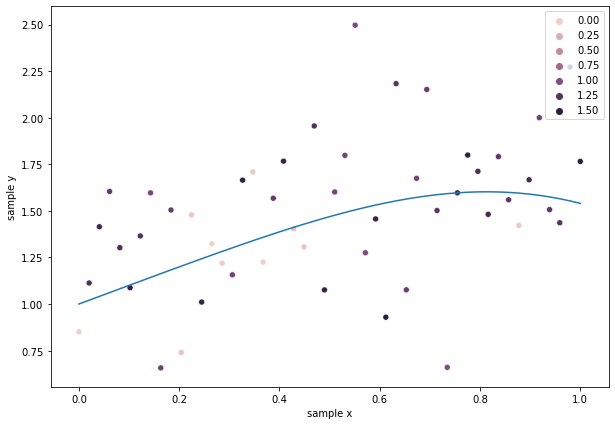

In [18]:
# def g(c):
#     return np.array([c ** 0, c, c ** 2]).squeeze()

def g_tilde(c, w_0=0.5, w_1=7, w_2 = 10):
    return w_0 + w_1  * c + w_2 *c**2




def g(c, w_0=0.5, w_1=7, w_2 = 10):
    return g_tilde(c, w_0, w_1, w_2)/g_tilde(6, w_0, w_1, w_2) * mu**2




w_0 = 1.1
w_1 = np.sqrt(1.5)
w_2 = np.sqrt(np.sqrt(0.1))
w = np.array([w_0, w_1, w_2]).squeeze()

print(g_tilde(6, w_0, w_1, w_2))

w_0_equiv = 1.1/np.sqrt(21.594199576606165) 
w_1_equiv = np.sqrt(1.5)/np.sqrt(21.594199576606165) 
w_2_equiv = np.sqrt(np.sqrt(0.1))/np.sqrt(21.594199576606165) 
w_equiv = np.array([w_0_equiv, w_1_equiv, w_2_equiv]).squeeze()


def f_reg(x):
    
    return  x + np.cos(x**2)



num_samples = 50





X = np.linspace(0,1, num_samples)

C = np.concatenate(  (np.linspace(0.0, 0.1, 10), np.linspace(1., 1.5, num_samples - 10) ) )

np.random.shuffle(C)

print(w_equiv)

sigma2 = g_tilde(C, *w_equiv)/5


eps = []

for sigma in sigma2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
Y = f_reg(X) + eps

import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(X,
                Y,
                hue=C,
                )
plt.plot(X,f_reg(X))
plt.xlabel('sample x')
plt.ylabel('sample y')
plt.legend(loc='upper right');




In [19]:
#Linear regression

def phi(x):
    
    return np.array([1, np.cos(x), np.cos(2*x), np.cos(3*x), np.cos(4*x), np.cos(5*x)])



def log_likelihood_reg(f_0, alpha, Y, X, C, w, MPsi):
    
#     f_0 = beta[0]
#     alpha = beta[1:]
  
    l = 0
    
    for i in range(len(Y)):
        

        sigma2 = f(C[i], f_0, alpha, MPsi[i])
        
        fx = np.dot(w, phi(X[i]))
        
                
        l += -( fx - Y[i]  )**2/sigma2 - np.log(sigma2)
    
    
    return l

def logp_f_0(log_f, theta1, theta2):
    
    f_0 = np.exp(log_f)
    
    #return - (f_0-theta1)**2/theta2
    
    
    return  (theta1 -1)*log_f - theta2*f_0 + theta1*np.log(theta2) - np.log(gamma(theta1))

def logp_alpha(alpha, theta):
    
    
    l = 0
    
    for i in range(len(alpha)):
        
        if S(Lambda(i,L), theta) <= 0.0:
            print('Problema en S')
        
        l += -0.5*(alpha[i]**2/ S(Lambda(i,L), theta )) - 0.5*np.log(S(Lambda(i,L),theta ))
    
    return l


def logp_w(w):
    
    Sig = 1/(np.arange(6) + 1)**2
    
    return np.sum(-0.5*w**2/Sig - 0.5*np.log(Sig))


def log_p_reg(beta, w, theta1, theta2, theta, Y,X, C, MPsi):
    
    if beta[0] > 1000:
        print("aqui hay problema que g_0 es muy grande")
    
    f_0 = np.exp(beta[0]) 
    alpha = beta[1:]
    
    return logp_w(w) + logp_alpha(alpha, theta)+ logp_f_0(beta[0], theta1, theta2)+log_likelihood_reg(f_0, alpha, Y, X, C, w, MPsi)





In [20]:
theta1 = 3.0
theta2 = 3.
theta = np.array([2.06085246, 1.19000197])

# Theta = np.array([5,1, 1.0,1.0])



K = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        K[i,j] = ker(X[i], X[j])
        
        
beta_0 = np.ones(17)



N = len(beta_0) - 7


MPsi = []

for i in range(len(C)):
    
    MPsi.append(Psi(C[i],L, N))

In [21]:
#Hyper Parameters
import time

t0 = time.time()

#Hyper mean



# Kernel of the GP



def log_Evidence(theta, beta_0):
    
    print("evaluating log_evidence")
    
#     theta = Theta[:2]
#     theta1 = Theta[2]
#     theta2 = Theta[3]
    
#     theta = np.exp(log_theta)

    
    to_opti = lambda beta: -log_p_reg(beta[6:], beta[:6], theta1, theta2, theta, Y, X, C, MPsi)


    nab_p = lambda beta: grad(to_opti)(beta)
    
    
    Hess = lambda beta: jacobian(nab_p)(beta)

    beta = minimize(to_opti, beta_0 , jac=nab_p, hess = Hess, method='Newton-CG', options={"xtol": 0.01}).x
    
   
    A = Hess(beta_0)

    det = np.linalg.det(A*2*np.pi)
    
 
    
#     print( A )
    
    return -(-to_opti(beta) - 0.5*np.log(det))



def maximum_posterior(beta_0):
    
    to_opti = lambda beta: -log_p_reg(beta[6:], beta[:6], theta1, theta2, theta, Y, X, C, MPsi)


    nab_p = lambda beta: grad(to_opti)(beta)
    
    Hess = lambda beta: jacobian(nab_p)(beta)

    beta = minimize(to_opti, beta_0 , jac=nab_p, hess = Hess,method='Newton-CG').x
    
    
#     det = np.linalg.det(Hess*2*np.pi)
    
    return beta





# log_p(beta_0, 0.4, 0.4, 0.5, np.array([0.4, 0.4]), Y, X, C)

beta_0 = maximum_posterior(beta_0)
print(beta_0)
# print(beta_0)






# print(beta)
t0 = time.time()

theta_optimum = minimize(log_Evidence, theta, args=(beta_0,) , method='Powell', options = {'maxfev':40}).x
print(time.time() - t0)

print(theta_optimum)

# theta = np.exp(log_theta)

to_opti = lambda beta: -log_p_reg(beta[6:], beta[:6], theta1, theta2, theta_optimum, Y, X, C, MPsi)


nab_p = lambda beta: grad(to_opti)(beta)

beta = minimize(to_opti, beta_0, jac=nab_p, method='Newton-CG').x


print(theta_optimum)
print(beta)

to_sample = lambda beta: log_p_reg(beta[6:], beta[:6], theta1, theta2, theta_optimum, Y, X, C, MPsi)


grad_p = lambda beta: grad(to_sample)(beta)

def logprob(beta):
    
    return to_sample(beta), grad_p(beta) 


samples = hmc(logprob, x0=beta, n_samples=300, epsilon = 0.1)




[ 1.41985593  0.1125028  -0.13873457 -0.10285658 -0.03556238 -0.05902513
 -2.5340308   0.18937201  0.14441107 -0.2245366  -0.29428966  0.29890447
  0.45526602 -0.42115032 -0.63325348  0.60588967  0.83446331]
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence
evaluating log_evidence


/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return _np.array(args, *array_args, **array_kwargs)


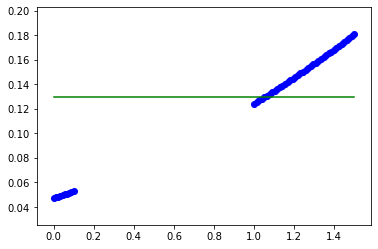

In [22]:
X_test = np.linspace(0,1,100)
C_test = np.linspace(0,1.5, 100)

sample_function = np.zeros((100, len(samples) ))

sample_g = np.zeros((100, len(samples) ))

MPsi_test = []

for i in range(len(C_test)):
    
    MPsi_test.append(Psi(C_test[i],L, N))



for i in range(len(samples)):
    
    sample_function[:,i] = np.dot(phi(X_test), samples[i][:6])
    
    for j in range(len(C_test)):
        sample_g[j,i] = f(C_test[j], np.exp(samples[i][6]), samples[i][7:], MPsi_test[j])
        
g_mean = np.mean(sample_g, axis = 1)

g_std = np.std(sample_g, axis = 1)


    
    
mean_function = np.mean(sample_function, axis = 1)
std_function = np.std(sample_function, axis = 1)


fig, ax = plt.subplots()

ax.scatter(C, sigma2, c='b', label = 'real function')
ax.plot(C_test, g_mean, c = 'g', label = 'reconstructed function')
ax.fill_between(C_test, g_mean -  g_std, g_mean +  g_std, alpha=0.3, label = 'uncertainty of reconstruction')




/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


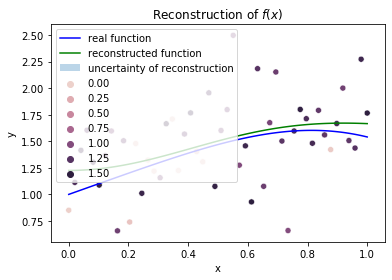

In [23]:
fig, ax = plt.subplots()

ax.plot(X_test, f_reg(X_test), c='b', label = 'real function')
ax.plot(X_test, mean_function, c = 'g', label = 'reconstructed function')
ax.fill_between(X_test, mean_function -  std_function,mean_function +  std_function, alpha=0.3, label = 'uncertainty of reconstruction')
# ax.plot(C_test, aproximate_mean -  aproximate_std)
ax.legend()


ax.set(xlabel='x', ylabel='y', title='Reconstruction of $f(x)$')

# ax.figure(figsize=(10, 7))
sns.scatterplot(X,
                Y,
                hue=C,
                )
# plt.plot(X,f_reg(X))
# plt.xlabel('sample x')
# plt.ylabel('sample y')
plt.legend(loc='upper left');



In [24]:





# previous experiments
def g(c, w_0=0.5, w_1=7, w_2 = 10):
    return w_0 ** 2 + (w_1 ** 2) * c + w_2 *c**2

num_samples = 20
mu = 3

w_0 = 1.1
w_1 = 2
w_2 = 0.1
w = np.array([w_0, w_1, w_2]).squeeze()

X = np.linspace(0,1, num_samples)

exp_mean = np.zeros((5,15))
alg_mean = np.zeros((5,15))
good_mean = np.zeros((5,15))
second_alg = np.zeros((5,15))



K = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        K[i,j] = ker(X[i], X[j])


beta_0 = np.array([0.4, 0.4, 1.0, 0.4, 0.4, 0.4, 0.5, 0.6, 1, 2]) +10

alpha_alg = np.zeros((5, 15, len(beta_0) - 1))




for i in range(5):
    
    for j in range(15):
    
        good_points = 4*(i+1)



        C = np.concatenate(  (np.random.uniform(0.5, 1.5, size = good_points), np.random.uniform(2., 6., size = num_samples - good_points) ) )

        sigma2 = g(C, *w)

        eps = []

        for sigma in sigma2:
            assert sigma > 0, f'Sigma is {sigma}'
            noise = norm(scale=sigma ** 0.5).rvs(1)
            eps.append(noise)

        eps = np.array(eps).squeeze()
        assert eps.shape == (num_samples,)
        Y = mu + eps
        
        exp_mean[i, j] = np.mean(Y) 
        good_mean[i,j] = np.mean(Y[0:good_points])
        
        
        MPsi = []

        for k in range(len(C)):
    
            MPsi.append(Psi(C[k],L, N))
        
        to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


        nab_p = lambda beta: grad(to_opti)(beta)
        
        beta = minimize(to_opti, beta_0 , jac=nab_p, method='Newton-CG').x
        
        aproximation = np.zeros(len(C))


        for l in range(num_samples):
    
            aproximation[l] = f(C[l], np.exp(beta[1]), beta[2:], MPsi[l])
    
        
        
        alg_mean[i,j] = beta[0]
        
        alpha_alg[i,j,:] = beta[1:]
        
        second_alg[i,j] = second_aprox(Y, aproximation)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 10)

In [ ]:
error_alg_20 = np.mean(np.absolute(alg_mean - mu)/mu, axis = 1)
error_exp_20 = np.mean(np.absolute(exp_mean - mu)/mu, axis = 1)
error_good_20 = np.mean(np.absolute(good_mean - mu)/mu, axis = 1)
error_second_20 = np.mean(np.absolute(second_alg - mu)/mu, axis = 1)


percentage = np.array([4, 8, 12, 16,20])/20 

fig, ax = plt.subplots()
ax.plot(percentage, error_alg_20, c = 'b', label = 'MPE')
ax.plot(percentage, error_exp_20, c = 'k', label = 'Experimental mean')
ax.plot(percentage, error_good_20, c = 'r', label = 'Experimental mean of good samples')
ax.plot(percentage, error_second_20, c = 'g', label = 'With approx. of the variance')

ax.legend()
ax.set(xlabel='Percentage of good points', ylabel='$E[| \mu - \hat{\mu}| ]/\mu$',
       title='Error in estimated $\mu$')


In [ ]:
# plt.plot(error_alg_40, c = 'b')
# plt.plot(error_exp_40, c = 'k')
# plt.plot(error_good_40, c = 'r')